In [1]:
import numpy as np 
import pandas as pd

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from xgboost import XGBClassifier
#import lightgbm as lgb
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report

import shap
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings('ignore')

# Data preprocessing & feature generation

In [2]:
data = pd.read_parquet('/kaggle/input/burger-king-churn/train_dataset_hackaton2023_train.gzip')
display(data.sample(5))

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
617977,652363,42.0,1,train,209.99,2023-01-23 13:46:36,Шримп Ролл,300.0,Отдельно стоящий без внешней зоны
19911842,29936669,18.0,1,train,39.99,2022-10-29 14:34:54,Кофе (МАЛ.),80.0,Фудкорт без туалета
17147500,26543301,NaN,0,train,275.99,2023-01-11 12:09:45,Двойной Чизбургер,466.0,Отдельно стоящий без внешней зоны без туалета
12292085,21427346,NaN,0,train,1.00,2023-03-01 21:13:43,Пиво Туборг Грин 0.5л розлив,303.0,Отдельно стоящий с внешней зоной
13648177,22702310,52.0,1,train,109.99,2022-09-17 21:03:08,Кинг Фри бол,111.5,Фудкорт без туалета


In [3]:
has_toilet_statuses = [
    "Отдельно стоящий с внешней зоной",
    "Отдельно стоящий без внешней зоны",
    "Отдельно стоящий",
    "Фудкорт с туалетом",
    "Отдельно стоящий с внешн.зоной без туалета",
]

hasnt_toilet_statuses = [
    "Фудкорт без туалета",
    "Отдельно стоящий без внешней зоны без туалета",
    "Отдельно стоящий без туалета",
]

with_external_zone = [
    "Отдельно стоящий с внешней зоной",
    "Отдельно стоящий с внешн.зоной без туалета",
]

without_external_zone = [
    "Отдельно стоящий без внешней зоны",
    "Отдельно стоящий без внешней зоны без туалета",
]

is_foodcourt = [
    "Фудкорт с туалетом",
    "Фудкорт без туалета",
]

proxy_features = [
    'orders_count',
    'monthly_orders_count',
    'last_month_orders_count',
    'dishes_count',
    'ownareaall_sqm'
]

revenue_proxy_features = [
    'revenue',
    'monthly_revenue',
    'last_month_revenue',
]

In [4]:
def group_by_customer(df, is_train=True):
    if is_train:
        df = df.groupby('customer_id').agg({
            'customer_id': 'first',

            'revenue': 'mean',
            'monthly_revenue': 'mean',
            'last_month_revenue': 'first',

            'has_toilet': 'sum',
            'has_external_zone': 'sum',
            'is_foodcourt': 'sum',
    
            'orders_count': 'sum',
            'monthly_orders_count': 'mean',
            'last_month_orders_count': 'first',
    
            'ownareaall_sqm': 'mean',
            'dishes_count': 'mean',
            'date_diff_post': 'mean',
            'buy_post': 'first',
        }).reset_index(drop=True)
    else:
        df = df.groupby('customer_id').agg({
            'customer_id': 'first',

            'revenue': 'mean',
            'monthly_revenue': 'mean',
            'last_month_revenue': 'first',

            'has_toilet': 'sum',
            'has_external_zone': 'sum',
            'is_foodcourt': 'sum',
    
            'orders_count': 'sum',
            'monthly_orders_count': 'mean',
            'last_month_orders_count': 'first',
    
            'ownareaall_sqm': 'mean',
            'dishes_count': 'mean'
        }).reset_index(drop=True)
    
    return df

In [5]:
def preprocess(data, is_train=True):
    
    if is_train:
        data = data[data.format_name != 'Не заполнено']
        #slight date_diff_post aligning
        data.date_diff_post.fillna(-1, inplace=True)
        data.date_diff_post = data.date_diff_post.astype(int)
    
    # make has_toilet column and store there true or false based on has_toilet_statuses
    data['has_toilet'] = data.format_name.isin(has_toilet_statuses)

    # if has external zone then store 2, else 1, if not in with/without_external_zone then store 0
    data['has_external_zone'] = data.format_name.apply(
        lambda x: 2 if x in with_external_zone else 1 if x in without_external_zone else 0
    )

    # 2 - has external zone
    # 1 - hasnt external zone
    # 0 - not defined

    data['is_foodcourt'] = data.format_name.isin(is_foodcourt)

    data.drop('format_name', axis=1, inplace=True)
    
    if is_train:
        # filter outliers in dish_name that have less than 10000 rows
        dish_name_counts = data.dish_name.value_counts()
        dish_name_counts = dish_name_counts[dish_name_counts > 50000]
        data = data[data.dish_name.isin(dish_name_counts.index)]
    
    # create bill_id based on startdatetime and customer_id
    data['bill_id'] = data.groupby(['startdatetime', 'customer_id']).ngroup()
    
    # drop group_name
    data.drop('group_name', axis=1, inplace=True)
    
    # label encode dish_name
    le = LabelEncoder()
    data['dish_name'] = le.fit_transform(data.dish_name)
    
    if is_train:
        data = data.groupby('bill_id').agg({
            'bill_id': 'first',
            'customer_id': 'first',
            'dish_name': list,
            'startdatetime': 'first',
            'has_toilet': 'first',
            'has_external_zone': 'first',
            'is_foodcourt': 'first',
            'date_diff_post': 'first',
            'buy_post': 'first',
            'revenue': 'sum',
            'ownareaall_sqm': 'first',
        }).reset_index(drop=True)
    else:
        data = data.groupby('bill_id').agg({
            'bill_id': 'first',
            'customer_id': 'first',
            'dish_name': list,
            'startdatetime': 'first',
            'has_toilet': 'first',
            'has_external_zone': 'first',
            'is_foodcourt': 'first',
            'revenue': 'sum',
            'ownareaall_sqm': 'first',
        }).reset_index(drop=True)
    
    data['dish_amount'] = [len(n) for n in data['dish_name']]
    
    #generating even more features!
    # group data by customer_id
    data['dishes_count'] = data.dish_name.apply(lambda x: len(x))
    data['orders_count'] = data.groupby('customer_id')['bill_id'].transform('nunique')

    # count amount of orders for every month
    data['monthly_orders_count'] = data.groupby(['customer_id', data.startdatetime.dt.month])['bill_id'].transform('nunique')
    data['monthly_revenue'] = data.groupby(['customer_id', data.startdatetime.dt.month])['revenue'].transform('sum')

    # get last month
    last_month = data.startdatetime.dt.month.max()
    # get last month orders count
    data['last_month_orders_count'] = data[data.startdatetime.dt.month == last_month].groupby('customer_id')['bill_id'].transform('nunique')
    # get last month revenue
    data['last_month_revenue'] = data[data.startdatetime.dt.month == last_month].groupby('customer_id')['revenue'].transform('sum')
    
    #datetime to timestamp
    data['startdatetime'] = [datetime.timestamp(n) for n in data['startdatetime']]
    
    for feature in proxy_features:
        data[feature].fillna(0, inplace=True)
        data[feature] = data[feature].round().astype(int)
    
    for feature in revenue_proxy_features:
        data[feature].fillna(0, inplace=True)
        data[feature] = data[feature].round(2).astype(float)
    
    return group_by_customer(data, is_train)

In [6]:
data = preprocess(data)
data.sample(5)

,customer_id,revenue,monthly_revenue,last_month_revenue,has_toilet,has_external_zone,is_foodcourt,orders_count,monthly_orders_count,last_month_orders_count,ownareaall_sqm,dishes_count,date_diff_post,buy_post
120090,10105144,374.983333,1286.610000,0.0,5,5,1,36,3.333333,0,247.000000,7.333333,13.0,1
239120,21277095,251.660000,419.986667,0.0,3,0,3,9,1.666667,0,110.666667,4.666667,14.0,1
236143,21132323,175.326667,303.990000,0.0,3,0,3,9,1.666667,0,300.000000,2.333333,49.0,1
58084,5721526,476.351667,2858.110000,0.0,3,6,3,36,6.000000,0,412.000000,3.333333,33.0,1
259884,22253571,209.980000,373.300000,0.0,0,0,3,9,1.666667,0,133.000000,2.333333,-1.0,0


In [7]:
cat_feat = ['has_external_zone', 'has_toilet', 'is_foodcourt']

# Train test split

In [8]:
x = data[[column for column in data.columns if column not in ['buy_post', 'date_diff_post', 'customer_id', 'dish_name', 'bill_id']]]
y = data[['buy_post', 'date_diff_post']]
y_clf = y['buy_post']
y_reg = y['date_diff_post']

x_train, x_test, y_train, y_test = train_test_split(x, y)
y_train_clf, y_test_clf = y_train['buy_post'], y_test['buy_post']
y_train_reg, y_test_reg = y_train['date_diff_post'], y_test['date_diff_post'] 

In [9]:
train_pool_clf = Pool(x_train, y_train_clf, cat_features=cat_feat)
eval_pool_clf = Pool(x_test, y_test_clf, cat_features=cat_feat)
full_train_clf = Pool(x, y_clf, cat_features=cat_feat)

train_pool_reg = Pool(x_train, y_train_reg, cat_features=cat_feat)
eval_pool_reg = Pool(x_test, y_test_reg, cat_features=cat_feat)
full_train_reg = Pool(x, y_reg, cat_features=cat_feat)

# Model training

In [10]:
cbc = CatBoostClassifier(iterations=100, learning_rate=0.4, depth=8, l2_leaf_reg=10, loss_function='Logloss')
cbc.fit(train_pool_clf, eval_set=eval_pool_clf)

0:	learn: 0.6105323	test: 0.6096156	best: 0.6096156 (0)	total: 167ms	remaining: 16.5s
1:	learn: 0.5743268	test: 0.5728128	best: 0.5728128 (1)	total: 278ms	remaining: 13.6s
2:	learn: 0.5584012	test: 0.5565904	best: 0.5565904 (2)	total: 380ms	remaining: 12.3s
3:	learn: 0.5509648	test: 0.5488530	best: 0.5488530 (3)	total: 492ms	remaining: 11.8s
4:	learn: 0.5476281	test: 0.5453995	best: 0.5453995 (4)	total: 589ms	remaining: 11.2s
5:	learn: 0.5452065	test: 0.5429161	best: 0.5429161 (5)	total: 687ms	remaining: 10.8s
6:	learn: 0.5437853	test: 0.5414472	best: 0.5414472 (6)	total: 784ms	remaining: 10.4s
7:	learn: 0.5428890	test: 0.5405958	best: 0.5405958 (7)	total: 883ms	remaining: 10.2s
8:	learn: 0.5423876	test: 0.5401085	best: 0.5401085 (8)	total: 975ms	remaining: 9.86s
9:	learn: 0.5419823	test: 0.5397589	best: 0.5397589 (9)	total: 1.07s	remaining: 9.62s
10:	learn: 0.5417165	test: 0.5395171	best: 0.5395171 (10)	total: 1.17s	remaining: 9.47s
11:	learn: 0.5414926	test: 0.5394224	best: 0.5394224

In [11]:
cbr = CatBoostRegressor(iterations=100, learning_rate=0.4, depth=8, l2_leaf_reg=10)
cbr.fit(train_pool_reg, eval_set=eval_pool_reg)

0:	learn: 17.3891667	test: 17.3306244	best: 17.3306244 (0)	total: 110ms	remaining: 10.9s
1:	learn: 17.3541185	test: 17.2940247	best: 17.2940247 (1)	total: 215ms	remaining: 10.6s
2:	learn: 17.3377307	test: 17.2771491	best: 17.2771491 (2)	total: 305ms	remaining: 9.85s
3:	learn: 17.3209802	test: 17.2594469	best: 17.2594469 (3)	total: 412ms	remaining: 9.88s
4:	learn: 17.3146869	test: 17.2533245	best: 17.2533245 (4)	total: 513ms	remaining: 9.74s
5:	learn: 17.3110179	test: 17.2501893	best: 17.2501893 (5)	total: 608ms	remaining: 9.53s
6:	learn: 17.3056921	test: 17.2460006	best: 17.2460006 (6)	total: 717ms	remaining: 9.53s
7:	learn: 17.3026835	test: 17.2434142	best: 17.2434142 (7)	total: 805ms	remaining: 9.25s
8:	learn: 17.2996976	test: 17.2411942	best: 17.2411942 (8)	total: 901ms	remaining: 9.11s
9:	learn: 17.2976847	test: 17.2399658	best: 17.2399658 (9)	total: 994ms	remaining: 8.95s
10:	learn: 17.2962400	test: 17.2395568	best: 17.2395568 (10)	total: 1.09s	remaining: 8.84s
11:	learn: 17.29222

In [12]:
'''
parameters = {'depth'         : [8, 10],
              'learning_rate' : [0.3, 0.4],
              'iterations'    : [10, 20],
              'l2_leaf_reg'   : [10, 15, 20]}
              
randomized_search_results = cbc.randomized_search(
    parameters,
    train_pool,
    n_iter=9,
    plot=True
)

randomized_search_results
'''

"\nparameters = {'depth'         : [8, 10],\n              'learning_rate' : [0.3, 0.4],\n              'iterations'    : [10, 20],\n              'l2_leaf_reg'   : [10, 15, 20]}\n              \nrandomized_search_results = cbc.randomized_search(\n    parameters,\n    train_pool,\n    n_iter=9,\n    plot=True\n)\n\nrandomized_search_results\n"

## Making an ansamble

In [13]:
xgbc_train = x_train.copy()
xgbc_train['cbc_0'] = [n[0] for n in cbc.predict_proba(x_train)]
xgbc_train['cbc_1'] = [n[1] for n in cbc.predict_proba(x_train)]
xgbc_train['cbr'] = cbr.predict(x_train)
xgbc_train.sample(5)

,revenue,monthly_revenue,last_month_revenue,has_toilet,has_external_zone,is_foodcourt,orders_count,monthly_orders_count,last_month_orders_count,ownareaall_sqm,dishes_count,cbc_0,cbc_1,cbr
275908,281.310000,511.290000,0.0,3,4,0,9,1.666667,0,262.0,1.666667,0.329519,0.670481,18.216258
261913,305.150000,1531.914167,0.0,12,12,0,144,5.166667,0,276.0,4.250000,0.034844,0.965156,9.204110
438886,282.472500,557.432500,0.0,0,0,4,16,2.500000,0,114.0,3.250000,0.254005,0.745995,19.161419
166211,283.560000,850.680000,0.0,1,1,2,9,3.000000,0,131.0,3.000000,0.488974,0.511026,16.314972
219333,233.306667,699.920000,0.0,3,3,0,9,3.000000,0,299.0,1.666667,0.492461,0.507539,15.149050


In [14]:
xgbc = XGBClassifier()
xgbc.fit(xgbc_train, y_train_clf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
'''
krs_train = pd.DataFrame()
krs_train['xgbc_0'] = [n[0] for n in xgbc.predict_proba(x_train)]
krs_train['xgbc_1'] = [n[1] for n in xgbc.predict_proba(x_train)]
krs_train['cbc_0'] = [n[0] for n in cbc.predict_proba(x_train)]
krs_train['cbc_1'] = [n[1] for n in cbc.predict_proba(x_train)]
krs_train['cbr'] = cbr.predict(x_train)
krs_train.sample(5)
'''

"\nkrs_train = pd.DataFrame()\nkrs_train['xgbc_0'] = [n[0] for n in xgbc.predict_proba(x_train)]\nkrs_train['xgbc_1'] = [n[1] for n in xgbc.predict_proba(x_train)]\nkrs_train['cbc_0'] = [n[0] for n in cbc.predict_proba(x_train)]\nkrs_train['cbc_1'] = [n[1] for n in cbc.predict_proba(x_train)]\nkrs_train['cbr'] = cbr.predict(x_train)\nkrs_train.sample(5)\n"

In [16]:
'''
krs = Sequential()
krs.add(Dense(5, activation='relu', input_shape=(8,)))
krs.add(Dense(5, activation='relu'))
krs.add(Dense(1, activation='sigmoid'))

krs.compile(loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

krs.fit(krs_train, y_train_clf, epochs=4, batch_size=64)
'''

"\nkrs = Sequential()\nkrs.add(Dense(5, activation='relu', input_shape=(8,)))\nkrs.add(Dense(5, activation='relu'))\nkrs.add(Dense(1, activation='sigmoid'))\n\nkrs.compile(loss='binary_crossentropy',\n    optimizer='adam',\n    metrics=['accuracy'])\n\nkrs.fit(krs_train, y_train_clf, epochs=4, batch_size=64)\n"

In [17]:
#y_pred = krs.predict_classes(_test)

In [18]:
#from keras.utils import plot_model
#plot_model(model, show_shapes=True)

# Evaluating model

In [19]:
xgbc_test = x_test.copy()
xgbc_test['cbc_0'] = [n[0] for n in cbc.predict_proba(x_test)]
xgbc_test['cbc_1'] = [n[1] for n in cbc.predict_proba(x_test)]
xgbc_test['cbr'] = cbr.predict(x_test)
display(xgbc_test.sample(5))

,revenue,monthly_revenue,last_month_revenue,has_toilet,has_external_zone,is_foodcourt,orders_count,monthly_orders_count,last_month_orders_count,ownareaall_sqm,dishes_count,cbc_0,cbc_1,cbr
142941,242.213333,897.516667,0.0,0,0,9,81,3.666667,0,110.0,3.000000,0.050173,0.949827,10.981444
197377,303.313333,909.940000,0.0,3,6,0,9,3.000000,0,160.0,2.666667,0.502204,0.497796,16.082018
7068,429.635000,1489.880000,0.0,5,0,1,36,3.333333,0,229.5,4.166667,0.127960,0.872040,19.588989
48963,429.970000,724.950000,0.0,0,0,3,9,1.666667,0,129.0,3.000000,0.328090,0.671910,18.865788
10582,270.485000,540.970000,0.0,2,0,1,4,2.000000,0,153.5,2.000000,0.476136,0.523864,16.326232


In [20]:
print(classification_report(y_test_clf, xgbc.predict(xgbc_test)))

              precision    recall  f1-score   support

           0       0.50      0.12      0.19     34719
           1       0.74      0.95      0.83     89441

    accuracy                           0.72    124160
   macro avg       0.62      0.54      0.51    124160
weighted avg       0.67      0.72      0.65    124160



In [21]:
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['F1'][:3])
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['Precision'][:3])
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['Recall'][:3])
print(cbc.eval_metrics(eval_pool_clf, metrics=['F1', 'Precision', 'Recall', 'Accuracy'])['Accuracy'][:3])

[0.8373108060542064, 0.8373108060542064, 0.8372307316201706]
[0.7215248232686802, 0.7215248232686802, 0.7223623899728228]
[0.9973613890721258, 0.9973613890721258, 0.9955389586431279]
[0.7208038015463918, 0.7208038015463918, 0.7211501288659794]


In [22]:
print(classification_report(y_test_clf, cbc.predict(x_test)))

              precision    recall  f1-score   support

           0       0.52      0.09      0.15     34719
           1       0.73      0.97      0.83     89441

    accuracy                           0.72    124160
   macro avg       0.63      0.53      0.49    124160
weighted avg       0.67      0.72      0.64    124160



In [23]:
print(cbr.eval_metrics(eval_pool_reg, metrics=['MAE', 'Poisson', 'RMSE'])['MAE'][:3])
print(cbr.eval_metrics(eval_pool_reg, metrics=['MAE', 'Poisson', 'RMSE'])['Poisson'][:3])
print(cbr.eval_metrics(eval_pool_reg, metrics=['MAE', 'Poisson', 'RMSE'])['RMSE'][:3])

[14.617872836336224, 14.552891528170797, 14.518430665867234]
[37112206.360173814, 47624614.04482683, 55567083.895312384]
[17.33062437911888, 17.29402465233015, 17.277149140255723]


In [24]:
cbc.get_feature_importance()

array([1.65934870e+00, 1.53162540e+00, 8.38923712e-01, 1.76781833e+00,
       6.19911793e-02, 1.21174226e+00, 6.36013428e+01, 2.39858081e+01,
       5.65795200e-01, 2.01301566e+00, 2.76258865e+00])

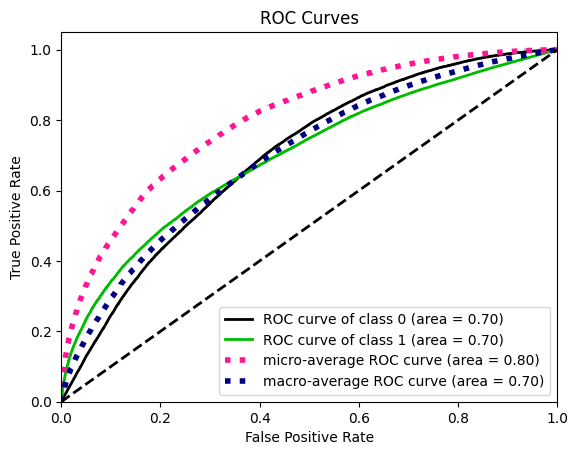

In [25]:
skplt.metrics.plot_roc_curve(y_test_clf, xgbc.predict_proba(xgbc_test))
plt.show()

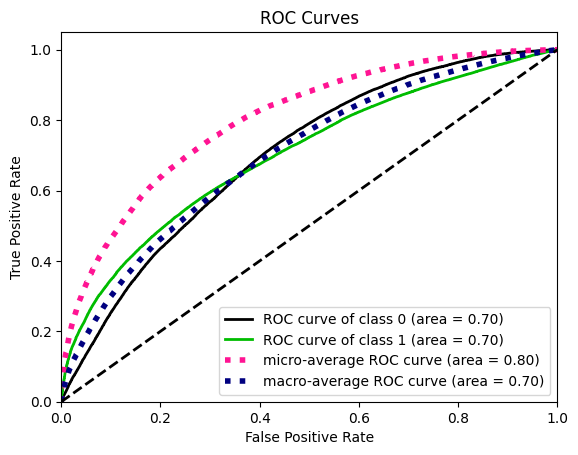

In [26]:
skplt.metrics.plot_roc_curve(y_test_clf, cbc.predict_proba(x_test))
plt.show()

In [27]:
shap.initjs()
explainer = shap.TreeExplainer(cbc)
shap_values = explainer.shap_values(eval_pool_clf)

In [28]:
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

In [29]:
shap.force_plot(explainer.expected_value, shap_values[0:100,:], x_train.iloc[0:100,:])

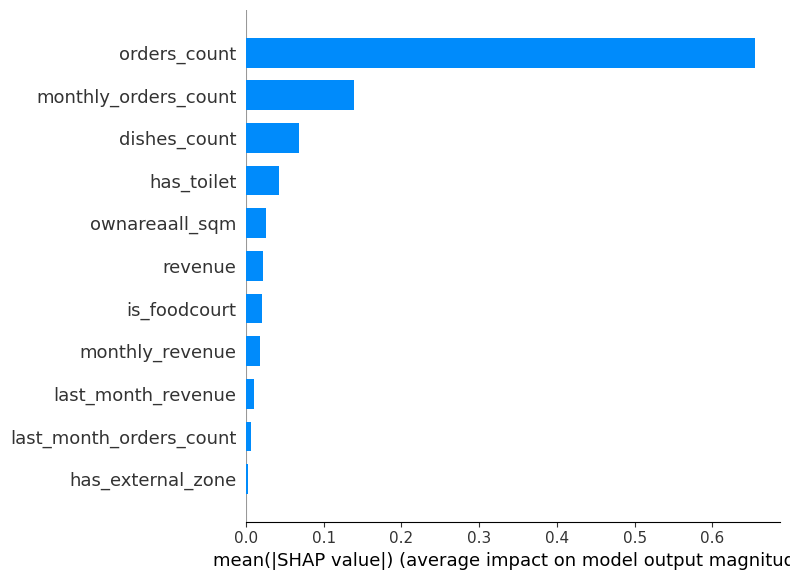

In [30]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

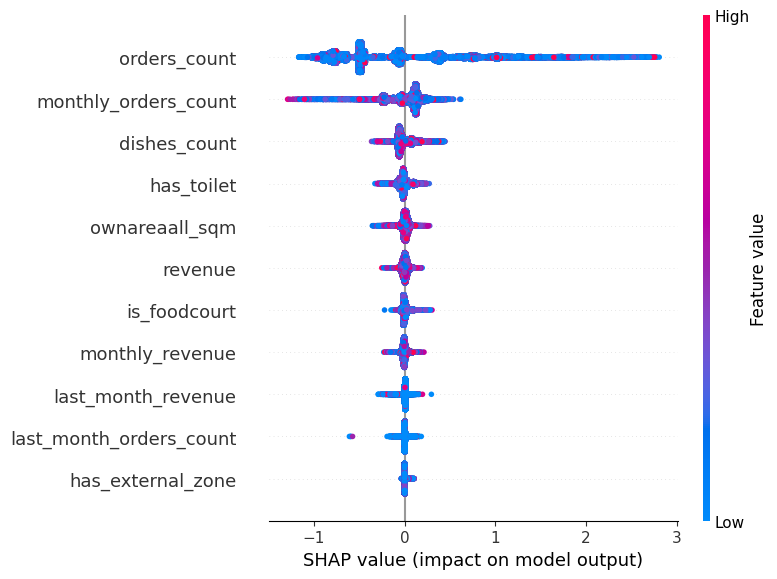

In [31]:
shap.summary_plot(shap_values[:100000], x_train[:100000])

# Train model on the full data

In [32]:
#cbc.load_model('/kaggle/working/cbc')
#cbr.load_model('/kaggle/working/cbc')
#xgbc.load_model('/kaggle/working/xgbc.json')

In [33]:
cbc = CatBoostClassifier(iterations=500, learning_rate=0.4, depth=8, l2_leaf_reg=10, loss_function='Logloss')
cbc.fit(full_train_clf, eval_set=eval_pool_clf)

0:	learn: 0.5945230	test: 0.5937085	best: 0.5937085 (0)	total: 446ms	remaining: 3m 42s
1:	learn: 0.5611096	test: 0.5598325	best: 0.5598325 (1)	total: 855ms	remaining: 3m 32s
2:	learn: 0.5498316	test: 0.5482541	best: 0.5482541 (2)	total: 1.28s	remaining: 3m 31s
3:	learn: 0.5456779	test: 0.5440390	best: 0.5440390 (3)	total: 1.63s	remaining: 3m 22s
4:	learn: 0.5431186	test: 0.5413561	best: 0.5413561 (4)	total: 2.04s	remaining: 3m 21s
5:	learn: 0.5424721	test: 0.5406935	best: 0.5406935 (5)	total: 2.43s	remaining: 3m 20s
6:	learn: 0.5418807	test: 0.5400699	best: 0.5400699 (6)	total: 2.81s	remaining: 3m 17s
7:	learn: 0.5413738	test: 0.5395978	best: 0.5395978 (7)	total: 3.14s	remaining: 3m 13s
8:	learn: 0.5410668	test: 0.5392742	best: 0.5392742 (8)	total: 3.53s	remaining: 3m 12s
9:	learn: 0.5407633	test: 0.5389629	best: 0.5389629 (9)	total: 3.96s	remaining: 3m 13s
10:	learn: 0.5405075	test: 0.5386678	best: 0.5386678 (10)	total: 4.33s	remaining: 3m 12s
11:	learn: 0.5403281	test: 0.5384794	best

In [34]:
cbr = CatBoostRegressor(iterations=500, learning_rate=0.4, depth=8, l2_leaf_reg=10)
cbr.fit(full_train_reg, eval_set=eval_pool_reg)

0:	learn: 17.3741291	test: 17.3295116	best: 17.3295116 (0)	total: 351ms	remaining: 2m 55s
1:	learn: 17.3343996	test: 17.2888987	best: 17.2888987 (1)	total: 682ms	remaining: 2m 49s
2:	learn: 17.3161525	test: 17.2699611	best: 17.2699611 (2)	total: 1.01s	remaining: 2m 46s
3:	learn: 17.3090072	test: 17.2629583	best: 17.2629583 (3)	total: 1.3s	remaining: 2m 41s
4:	learn: 17.2997822	test: 17.2527717	best: 17.2527717 (4)	total: 1.57s	remaining: 2m 35s
5:	learn: 17.2930179	test: 17.2452685	best: 17.2452685 (5)	total: 1.86s	remaining: 2m 33s
6:	learn: 17.2888874	test: 17.2411743	best: 17.2411743 (6)	total: 2.21s	remaining: 2m 35s
7:	learn: 17.2847626	test: 17.2363863	best: 17.2363863 (7)	total: 2.48s	remaining: 2m 32s
8:	learn: 17.2825271	test: 17.2340927	best: 17.2340927 (8)	total: 2.72s	remaining: 2m 28s
9:	learn: 17.2807670	test: 17.2320887	best: 17.2320887 (9)	total: 3.05s	remaining: 2m 29s
10:	learn: 17.2748489	test: 17.2254024	best: 17.2254024 (10)	total: 3.33s	remaining: 2m 28s
11:	learn

In [35]:
xgbc_x = x
xgbc_x['cbc_0'] = [n[0] for n in cbc.predict_proba(x)]
xgbc_x['cbc_1'] = [n[1] for n in cbc.predict_proba(x)]
xgbc_x['cbr'] = cbr.predict(x)
xgbc_x.sample(5)

,revenue,monthly_revenue,last_month_revenue,has_toilet,has_external_zone,is_foodcourt,orders_count,monthly_orders_count,last_month_orders_count,ownareaall_sqm,dishes_count,cbc_0,cbc_1,cbr
243481,261.6400,784.920,0.0,0,0,3,9,3.000000,0,108.00,3.333333,0.549210,0.450790,15.939975
404552,73.9925,147.985,0.0,1,2,3,16,2.000000,0,121.25,1.000000,0.208690,0.791310,19.274577
443279,730.1875,1460.375,0.0,4,8,0,16,2.000000,0,340.00,5.000000,0.212217,0.787783,19.676891
220098,314.7375,629.475,0.0,0,4,0,16,2.000000,0,180.00,5.250000,0.260624,0.739376,22.208287
307249,261.6500,909.940,0.0,1,1,5,36,3.333333,0,118.00,2.000000,0.137995,0.862005,17.047188


In [36]:
xgbc = XGBClassifier()
xgbc.fit(xgbc_x, y_clf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
cbc.save_model('cbc')
cbr.save_model('cbr')
xgbc.save_model('xgbc.json')

# Predicting results

In [38]:
test_data = pd.read_parquet('/kaggle/input/burger-king-churn/hackaton2023_test.gzip')
test_data.sample(5)

,customer_id,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
1862098,14642229,test,96.00,2022-12-12 15:50:45,Чай черный станд,366.10,Отдельно стоящий с внешней зоной
3988268,29925636,test,44.99,2023-01-09 16:21:04,Соус Сырный,106.60,Фудкорт без туалета
3998487,30007277,test,321.99,2022-12-26 08:17:13,Воппер с сыром,312.88,Отдельно стоящий
3593907,27701453,test,99.99,2022-10-30 13:26:54,Воппер Джуниор,340.10,Отдельно стоящий с внешней зоной
3459214,26735776,test,169.99,2022-11-27 19:40:48,Наггетсы (12 шт.),123.30,Фудкорт без туалета


In [39]:
print(len(test_data.customer_id.unique()))
test_data = preprocess(test_data, is_train=False)
print(len(test_data['customer_id'].unique()))
test_data.head()

112334
112334


,customer_id,revenue,monthly_revenue,last_month_revenue,has_toilet,has_external_zone,is_foodcourt,orders_count,monthly_orders_count,last_month_orders_count,ownareaall_sqm,dishes_count
0,52341,563.942500,1363.862500,0.00,4,8,0,16,2.500000,0,339.000000,7.000000
1,69175,430.306667,3010.817778,0.00,9,16,0,81,7.222222,0,255.000000,5.444444
2,73427,254.240323,3672.434516,0.00,29,6,4,961,15.129032,0,177.258065,2.064516
3,134577,372.970000,1491.880000,0.00,0,0,4,16,4.000000,0,208.000000,3.000000
4,156357,558.963333,867.943333,926.94,3,0,3,9,1.666667,2,128.333333,4.333333


In [40]:
out = pd.DataFrame()
out['customer_id'] = test_data['customer_id']
test_x = test_data[[column for column in data.columns if column not in ['buy_post', 'date_diff_post', 'customer_id', 'dish_name', 'bill_id']]]

out['date_diff_post'] = cbr.predict(test_x)
xgbc_test = test_x
xgbc_test['cbc_0'] = [n[0] for n in cbc.predict_proba(test_x)]
xgbc_test['cbc_1'] = [n[1] for n in cbc.predict_proba(test_x)]
xgbc_test['cbr'] = cbr.predict(test_x)
out['buy_post'] = xgbc.predict(xgbc_test)

print(out.dtypes)
out.head()

customer_id         int64
date_diff_post    float64
buy_post            int64
dtype: object


,customer_id,date_diff_post,buy_post
0,52341,20.947175,1
1,69175,17.822452,1
2,73427,7.153548,1
3,134577,14.799698,0
4,156357,21.818974,1


In [41]:
#aggregate predictions for paychecks to formulate a prediction for a single user
out = out.groupby('customer_id', as_index=False).mean().round(0)
out['date_diff_post'] = out['date_diff_post'].astype(int)
out['buy_post'] = out['buy_post'].astype(int)

for n, val in enumerate(out['buy_post']):
    if val == 0:
        out['date_diff_post'][n] = None
        
print(len(out.customer_id.unique()))
print(out.dtypes)
out.head()

112334
customer_id         int64
date_diff_post    float64
buy_post            int64
dtype: object


,customer_id,date_diff_post,buy_post
0,52341,21.0,1
1,69175,18.0,1
2,73427,7.0,1
3,134577,NaN,0
4,156357,22.0,1


In [42]:
out.to_csv('/kaggle/working/solution.csv', sep=';')